In [1]:

import scipy
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dasaset_folder = pathlib.Path('/home/alalbiol/Data/mamo/inbreast_yolo/validation/')


In [2]:
def read_gt(gt_file):
    gt = []
    with open(gt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            items = line.split()
            class_id = int(items[0])
            xc = float(items[1])
            yc = float(items[2])
            w = float(items[3])
            h = float(items[4])
            gt.append([xc, yc, w, h, class_id])
            
    
    return np.array(gt)

def read_yolo_pred(pred_file):
    with open(pred_file, 'r') as f:
        lines = f.readlines()
    preds = []
    for line in lines:
        line = line.strip()
        if len(line) == 0:
            continue
        items = line.split()
        xc = float(items[0])
        yc = float(items[1])
        w = float(items[2])
        h = float(items[3])
        class_id = int(float(items[4]))
        conf = float(items[5])
        pred = [xc, yc, w, h, class_id, conf]
        preds.append(pred)
        
    
    return np.array(preds)

In [3]:
all_gt = list(pathlib.Path(dasaset_folder / 'labels').glob('*.txt'))
print("num of gt files", len(list(all_gt)))

num of gt files 410


In [4]:
files_preds = list(pathlib.Path(dasaset_folder / 'fasterrcnn_predictions').glob('*.txt'))
files_gt = [str(f).replace('fasterrcnn_predictions', 'labels') for f in files_preds]

all_preds = [read_yolo_pred(f) for f in files_preds]
all_gt = [read_gt(f) for f in files_gt]

In [5]:
#Sort pred_boxes based on scores in descending order
def pred_inside_target(pred_box, target_box):
    cx = pred_box[0]
    cy = pred_box[1]
    
    xmin = target_box.xc - target_box.w/2
    xmax = target_box.xc + target_box.w/2
    ymin = target_box.yc - target_box.h/2
    ymax = target_box.yc + target_box.h/2
    
    if (cx > xmin) and (cx < xmax) and (cy > ymin) and (cy < ymax):
        return True

    return False


def calculate_FROC_curve(pred_boxes, target_boxes, class_id, thresholds=[0.7, 0.5, 0.3]):
    """ pred_boxes is a list for each image,
    each element is a list of boxes [x1, y1, x2, y2, class_id, confidence
    
    target_boxes is a list for each image,
    each element is a list of boxes [x1, y1, x2, y2, class_id]
    
    """
    
    target_num_boxes = np.zeros(len(target_boxes))
    pred_boxes_all = []
    
    
    total_num_of_predictions = 0
    total_num_positives = 0
    target_boxes_dict = {}
    for num_scan, (p, t) in enumerate(zip(pred_boxes, target_boxes)):
        if len(p) > 0:
            p = p[p[:,4]==class_id] 
            if len(p) > 0:
                p = np.hstack([p, np.ones((p.shape[0],1))*num_scan])
                pred_boxes_all.append(p)
                total_num_of_predictions += len(p)
        # print(num_scan, "target box", t)
        if len(t) > 0:
            t = t[t[:,4]==class_id]
            if len(t) > 0:
                target_boxes_dict[num_scan] = pd.DataFrame(t, columns=['xc', 'yc', 'w', 'h', 'class_id'])
                target_boxes_dict[num_scan]['target_box_id'] = [str(num_scan) + '_' + str(i) for i in range(len(t))]
            target_num_boxes[num_scan] += len(t) # can be empty
            total_num_positives += len(t)
        
    #put all pred boxes in a single list, and add a column with the image index
    
    
    print("Num of target boxes", total_num_positives)
    print("Num of pred boxes", total_num_of_predictions)
    # print("Num target boxes per scan", target_num_boxes)
    # print("sum of target boxes", np.sum(target_num_boxes))
    pred_boxes = np.vstack(pred_boxes_all)
    num_scans = len(pred_boxes)
    
    # print("Num scans", num_scans)
    
    
    # Sort pred_boxes based on scores in descending order
    pred_boxes = pred_boxes[np.argsort(pred_boxes[:, 5])[::-1]]
    
    
    # Initialize lists for true positives and false positives per scan for each threshold
    false_positives_per_scan = []
    sensitivity = []

    
    max_score = pred_boxes[:, -2].max()

    # Loop through each threshold
    for threshold in sorted(thresholds, reverse=False):
        if threshold > max_score:
            continue
            # Keep track of assigned target boxes
        assigned_target_boxes = list()

        positives = []  # List to store true positives and false positives
        detected_boxes = []  # List to store boxes detected above the threshold
        false_positives_per_scan_th = np.zeros(num_scans)
        #print("threshold", threshold)
        # Identify true positives and false positives
        for pred_box in pred_boxes:
            scan_index = int(pred_box[-1])
            if pred_box[-2] >= threshold:
                target_boxes_image = target_boxes_dict.get(scan_index,[])
                
                if len(target_boxes_image) == 0:
                    positives.append(0)
                    false_positives_per_scan_th[scan_index] += 1
                else:                   
                    # Check for intersection with unassigned target boxes
                    for k, target_box in target_boxes_image.iterrows():
                        if target_box['target_box_id'] not in assigned_target_boxes and pred_inside_target(pred_box[:4], target_box):
                            assigned_target_boxes.append(target_box['target_box_id'])
                            detected_boxes.append(pred_box)
                            positives.append(1)  # True positive
                            if len(assigned_target_boxes) > total_num_positives:
                                print("Error, more than total_num_positives")
                        else:
                            positives.append(0) # False positive
                            false_positives_per_scan_th[scan_index] += 1

        # Calculate mean false positives per scan
        
    
        false_positives_per_scan.append(np.mean(false_positives_per_scan_th))
        sensitivity.append(np.sum(positives)/total_num_positives)
        

    return false_positives_per_scan, sensitivity
    



In [6]:
fp, sens = calculate_FROC_curve(all_preds[:], all_gt[:], 1, thresholds=np.linspace(0, 1.0, 100))

Num of target boxes 102
Num of pred boxes 2047


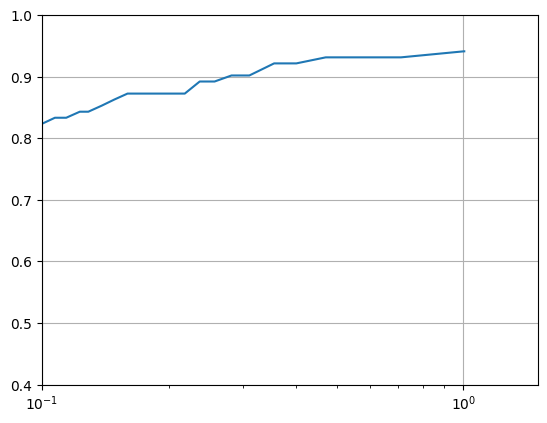

In [17]:
plt.plot(fp, sens)

#reapeat plot in xlog scale any y axis between 0.4 and 1
plt.xscale('log')
plt.xlim(0.1, 1.5)
plt.ylim(0.4, 1)
plt.grid(True)

In [18]:

#find fp at 0.9 sensitivity
thresholds=np.linspace(0, 1.0, 100)
sens = np.array(sens)
fp = np.array(fp)
index = np.where(sens < 0.9)[0][0]
print("false positives per image",  fp[index],  "at 0.9 sensitivity")

false positives per image 0.25696140693698094 at 0.9 sensitivity


0.09090909090909091

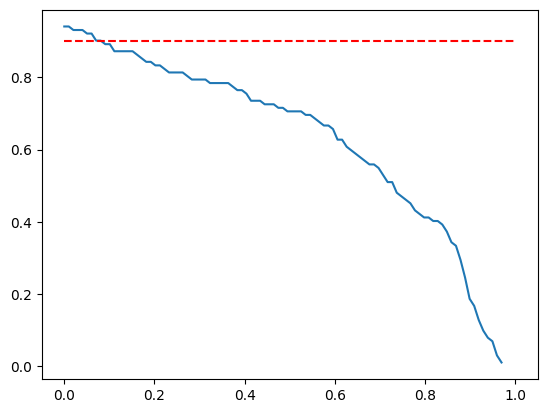

In [24]:
plt.plot(thresholds[:len(sens)], sens)
plt.plot([0,1], [0.9,0.9], 'r--')
thresholds[index]